# GMRES

GMRES is simply the replacement of the problem "solve $b-Ax=0$ with "minimize $\|b-Ax\|$ over $\mathcal{K}_n$". Its convergence depends strongly on (at least) the spectrum of $A$.

This example is adapted from the text.

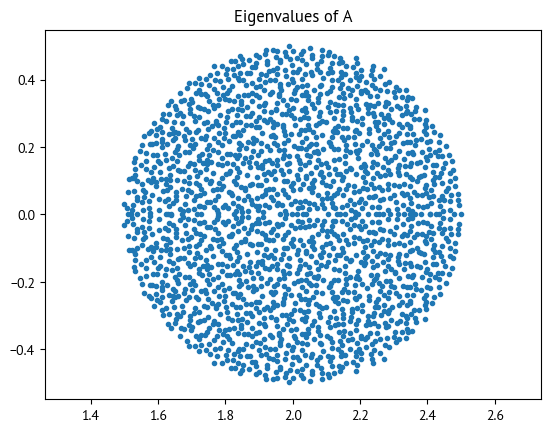

In [1]:
using LinearAlgebra,PyPlot

m = 2000;
A = 2I + 0.5*randn(m,m)/sqrt(m);
lam = eigvals(A);
plot(real(lam),imag(lam),".");
axis("equal");
title("Eigenvalues of A");

Here's the Arnoldi iteration again.

In [ ]:
function arnoldi(A,nmax)
    m = size(A,1)
    Q = zeros(m,nmax+1);
    H = zeros(nmax+1,nmax);
    Q[:,1] = b/norm(b);
    for n = 1:nmax
        v = A*Q[:,n]
        for i = 1:n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
    end
    return H,Q
end

All we need to do is use the information after each $n$ to solve the least squares problem min $\|b-Ax\|=\|Q_n^*b-H_n z\|$, in which $x=Q_nz$. Furthermore, $Q_n^*b=\|b\|e_1$. 

In [2]:
function GMRES(A,b,nmax)
    m = size(A,1)
    Q = zeros(eltype(A),m,nmax+1);
    H = zeros(eltype(A),nmax+1,nmax);
    nrmb = norm(b)
    Q[:,1] = b/nrmb
    resnorm = zeros(nmax)
    for n = 1:nmax
        v = A*Q[:,n]
        for i = 1:n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
        
        Qtb = [nrmb;zeros(n)]
        global z = H[1:n+1,1:n] \ Qtb
        resnorm[n] = norm( H[1:n+1,1:n]*z - Qtb ) / nrmb
    end
    x = Q[:,1:nmax]*z
    return x,resnorm
end

GMRES (generic function with 1 method)

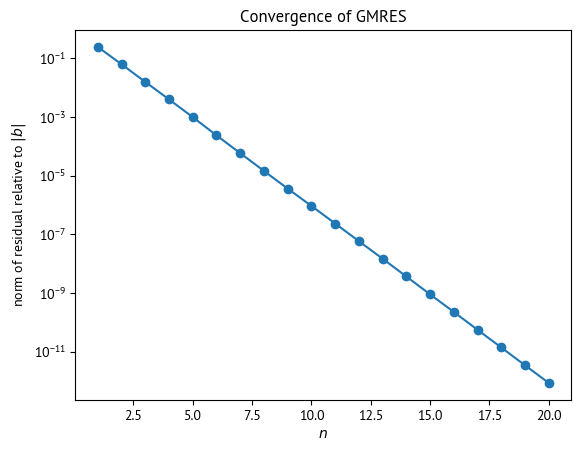

In [3]:
b = ones(m)
x,resnorm = GMRES(A,b,20)
semilogy(1:20,resnorm,"o-");
xlabel(L"$n$"), ylabel(L"norm of residual relative to $\|b\|$");
title("Convergence of GMRES");

The text explains why this curve might be very close to $4^{-n}$. 

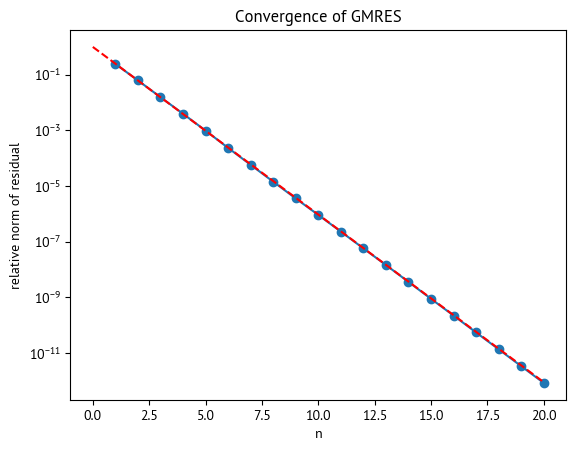

In [4]:
semilogy(1:20,resnorm,"o-");
semilogy(0:20,.25 .^(0:20),"r--");
xlabel("n"), ylabel("relative norm of residual");
title("Convergence of GMRES");

The rate is tied to how easy it is to make a polynomial small on the spectrum of $A$ while satisfying the normalization $p(0)=1$. If the eigenvalues get close to or surround the origin, this becomes difficult.

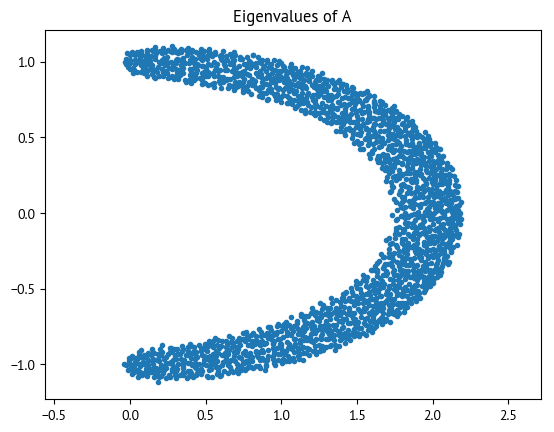

In [5]:
theta = pi*(0:m-1)/(m-1)
d = @. (-2+2*sin(theta)) + 1im*cos(theta)
D = Diagonal(d)
A = A + D
lam = eigvals(A)
plot(real(lam),imag(lam),".")
axis("equal") 
title("Eigenvalues of A");

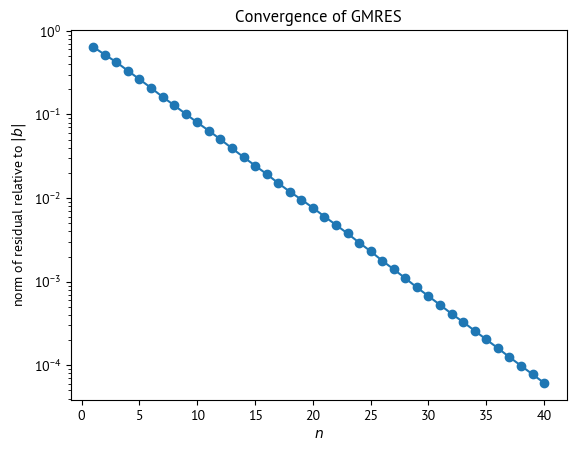

In [6]:
b = ones(m,1);
x,resnorm = GMRES(A,b,40)
semilogy(1:40,resnorm,"o-");
xlabel(L"$n$"), ylabel(L"norm of residual relative to $\|b\|$");
title("Convergence of GMRES");

There is again a linear convergence rate, but a much slower one this time due to the shape of the spectrum.

## Restarting

The main drawback to GMRES is that as the iteration counter $n$ grows, the amount of work per iteration grows as well. (The growing storage of the orthnormal Arnoldi basis can be an issue as well.) An easy and sometimes effective response is *restarting* the iteration.

Suppose we are solving $Ax=b$ and arrive at an approximation $x_n$. Defining $y=x-x_n$, we get the equivalent system $Ay = b - Ax_n=r_n$, the final residual. (In a linear problem, "A times error=residual.") So we restart GMRES to solve the problem $Ay=r_n$. Ideally, $\|r_n\|$ is much less than $\|b\|$, so we require that much less reduction in the residual. 

Any software for GMRES will do this process for you automatically. In this example, we spice things up a little by making $A$ nonnormal.

In [ ]:
using IterativeSolvers
# m = 2000
# theta = pi*(0:m-1)/(m-1)
# d = @. (-2+2*sin(theta)) + 1im*cos(theta)
# D = Diagonal(d)
# A = 2I + 0.5*randn(m,m)/sqrt(m) + D
V = diagm(0=>ones(m))
V[1,m] = 1000
A = V*A/V
b = ones(m)
for restart = 5:5:20
    x,his = gmres(A,b,restart=restart,maxiter=80,tol=1e-6,log=true)
    semilogy(his[:resnorm]/norm(b),"-o")
end
x,his = gmres(A,b,restart=m,maxiter=80,tol=1e-6,log=true)
semilogy(his[:resnorm]/norm(b),"k-o")

By definition, all of these are the same up to the first restart. After that, the methods are no longer optimizing over the same spaces, and none can be better than the unrestarted case (which uses the full Krylov spaces). If we restart too frequently, the spaces never gather enough information to make progress. 

Be careful though. The whole point is that the iterations are not equally time-consuming in all these cases. When you compare running time, you can find that a modest restart is really the best option.

In [ ]:
for restart = 10:5:50
    @time x,his = gmres(A,b,restart=restart,maxiter=500,tol=1e-12,log=true)
    @show his
end